In [169]:
nest_patient = [
    775,  787,  788, 1123, 1169, 1170, 1171, 1172, 1173, 1983, 2110, 2195,
    2955, 2956, 2957, 2958, 2959, 2960, 2961, 2962, 2963, 3081, 3229, 3318, 3432
]

In [170]:
rgs_mode = "app"
scoring_weights = [1,1,1]
ewma_alpha = 0.2

n = 12
days = 7
protocols_per_day = 5

In [171]:
%load_ext autoreload
%autoreload 2
import pandas as pd
from ai_cdss.data_loader import DataLoader
from ai_cdss.data_processor import DataProcessor
from ai_cdss.constants import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### LOAD NEST

In [172]:
loader = DataLoader(rgs_mode=rgs_mode)
processor = DataProcessor(weights=scoring_weights, alpha=ewma_alpha)

In [178]:
session = loader.load_session_data(patient_list=nest_patient)
timeseries = loader.load_timeseries_data(patient_list=nest_patient)
ppf = loader.load_ppf_data(patient_list=nest_patient)
protocol_similarity = loader.load_protocol_similarity()
protocol_metrics = loader.load_protocol_init()

Database engine created successfully


INFO:ai_cdss.data_loader:Session data loaded successfully.


Database engine closed
Database engine created successfully
Database engine closed
Database engine created successfully
Database engine closed


INFO:ai_cdss.data_loader:PPF data loaded successfully.
INFO:ai_cdss.data_loader:Protocol similarity data loaded successfully.
INFO:ai_cdss.data_loader:Protocol similarity data loaded successfully.


In [174]:
init_metrics = loader.load_protocol_init()

INFO:ai_cdss.data_loader:Protocol similarity data loaded successfully.


In [175]:
session = session.dropna(subset=["ADHERENCE"])

In [ ]:
ss = processor.preprocess_sessions(session)
ts = processor.preprocess_timeseries(timeseries)
df = ss.merge(ts, on=BY_PPS)


df_protocol = df.groupby(by=BY_PP)[FINAL_METRICS].last()
df_all = ppf.merge(df_protocol, on=BY_PP, how="left")

In [ ]:
# Initialize missing values
# protocol_metrics = pd.read_csv("init_metrics.csv")
# score = processor._init_metrics(df_all, protocol_metrics)

In [ ]:
# score[(score[PATIENT_ID] == 775) & (score[USAGE] != 0)]

### SIMULATION

In [179]:
def yield_cumulative_weeks(session: pd.DataFrame, timeseries: pd.DataFrame):
    session = session.copy()
    timeseries = timeseries.copy()

    # Normalize datetime (remove time-of-day)
    session["SESSION_DATE"] = pd.to_datetime(session["SESSION_DATE"]).dt.floor("D")

    # Create 7-day bins starting from first session date
    first_day = session["SESSION_DATE"].min()
    last_day = session["SESSION_DATE"].max()
    weekly_bins = pd.date_range(start=first_day, end=last_day + pd.Timedelta(days=7), freq="7D")
    week_labels = [f"Week {i+1}" for i in range(len(weekly_bins) - 1)]

    # Assign weekly labels to session data
    session["WEEK"] = pd.cut(
        session["SESSION_DATE"],
        bins=weekly_bins,
        labels=week_labels,
        right=False
    )

    # Merge WEEK info into timeseries
    timeseries = timeseries.merge(
        session[["PATIENT_ID", "SESSION_ID", "WEEK"]],
        on=["PATIENT_ID", "SESSION_ID"],
        how="left"
    )

    # Yield incrementally growing weeks
    for i in range(1, len(week_labels) + 1):
        active_weeks = week_labels[:i]

        session_i = session[session["WEEK"].isin(active_weeks)].copy()
        timeseries_i = timeseries[timeseries["WEEK"].isin(active_weeks)].copy()

        yield i, session_i, timeseries_i

In [180]:
scores_list = []
for week_idx, sess, ts in yield_cumulative_weeks(session, timeseries):

    # Which patients
    patients = sess.PATIENT_ID.unique()
    ppf = loader.load_ppf_data(patient_list=patients)

    # Check patients present
    scores = processor.process_data(sess, ts, ppf, init_metrics)
    scores["WEEK"] = week_idx
    scores_list.append(scores)

scores_df = pd.concat(scores_list)

INFO:ai_cdss.data_loader:PPF data loaded successfully.
INFO:ai_cdss.data_loader:PPF data loaded successfully.
INFO:ai_cdss.data_loader:PPF data loaded successfully.
INFO:ai_cdss.data_loader:PPF data loaded successfully.
INFO:ai_cdss.data_loader:PPF data loaded successfully.
INFO:ai_cdss.data_loader:PPF data loaded successfully.
INFO:ai_cdss.data_loader:PPF data loaded successfully.
INFO:ai_cdss.data_loader:PPF data loaded successfully.
INFO:ai_cdss.data_loader:PPF data loaded successfully.
INFO:ai_cdss.data_loader:PPF data loaded successfully.
INFO:ai_cdss.data_loader:PPF data loaded successfully.
INFO:ai_cdss.data_loader:PPF data loaded successfully.
INFO:ai_cdss.data_loader:PPF data loaded successfully.
INFO:ai_cdss.data_loader:PPF data loaded successfully.
INFO:ai_cdss.data_loader:PPF data loaded successfully.
INFO:ai_cdss.data_loader:PPF data loaded successfully.
INFO:ai_cdss.data_loader:PPF data loaded successfully.
INFO:ai_cdss.data_loader:PPF data loaded successfully.
INFO:ai_cd

In [181]:
scores_dynamic = scores_df[scores_df[USAGE] != 0]

In [ ]:
# Ensure it's sorted by patient and global week
scores_df = scores_df.sort_values(by=["PATIENT_ID", "WEEK"])

# Create a relative week index per patient
scores_df["RELATIVE_WEEK"] = (
    scores_df.groupby("PATIENT_ID")["WEEK"]
    .rank(method="dense")  # duplicates get the same rank
    .astype("int")
)

scores_study = scores_df[scores_df["RELATIVE_WEEK"] <= 6].reset_index(drop=True)

In [187]:
scores_study

,PATIENT_ID,PROTOCOL_ID,PPF,CONTRIB,ADHERENCE,DM_VALUE,PE_VALUE,USAGE,DAYS,SCORE,WEEK,RELATIVE_WEEK
0,775,10,0.383888,"[0.0, 0.0, 0.0, 0.09743346255755155, 0.2864543...",0.000000,0.000000,0.0,0,0,0.383888,1,1
1,775,200,0.358752,"[0.0, 0.0, 0.0, 0.07597986781430996, 0.2233808...",0.532875,0.000000,0.0,0,0,0.891627,1,1
2,775,201,0.632038,"[0.022302696143133578, 0.07434232047711194, 0....",0.814945,0.000715,0.0,0,0,1.447699,1,1
3,775,202,0.707386,"[0.0, 0.10411017707694051, 0.07808263280770539...",0.874789,0.000709,0.0,0,0,1.582883,1,1
4,775,203,0.683612,"[0.0, 0.0798716715027359, 0.05990375362705192,...",0.763286,0.000000,0.0,0,0,1.446897,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
4459,3318,229,0.557248,"[0.0, 0.0, 0.0, 0.14178490207925287, 0.4154627...",0.192236,0.005009,0.0,0,0,0.754493,39,6
4460,3318,230,0.613689,"[0.0, 0.0, 0.0, 0.16863097251377238, 0.3705959...",0.646056,0.010354,0.0,0,0,1.270099,39,6
4461,3318,231,0.561826,"[0.0, 0.0, 0.0, 0.1902244075394164, 0.37160116...",0.891341,0.002553,0.0,0,0,1.455720,39,6
4462,3318,232,0.557248,"[0.0, 0.0, 0.0, 0.14178490207925287, 0.4154627...",0.207842,0.007591,0.0,0,0,0.772681,39,6


In [190]:
scores_study_clean = scores_study[["PATIENT_ID","SCORE","RELATIVE_WEEK"]]

In [ ]:
scores_study_cleean

`Population Score`

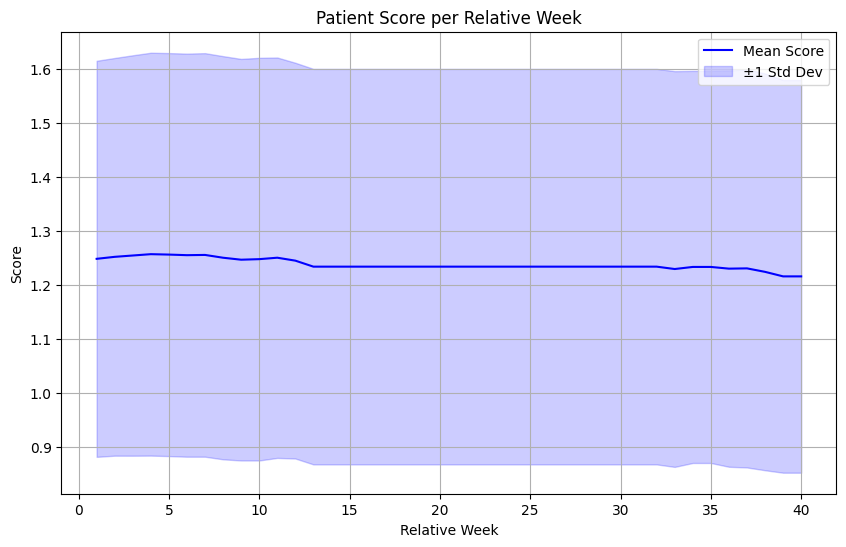

In [191]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your DataFrame is already loaded as scores_df
# Example: scores_df = pd.read_csv("your_data.csv")

# Group by RELATIVE_WEEK, compute mean and std
grouped = scores_df.groupby("RELATIVE_WEEK")["SCORE"].agg(['mean', 'std'])

# Prepare X and Y
x = grouped.index
mean_score = grouped['mean']
std_score = grouped['std']

# Plot
plt.figure(figsize=(10, 6))
plt.plot(x, mean_score, label='Mean Score', color='blue')
plt.fill_between(x, mean_score - std_score, mean_score + std_score, color='blue', alpha=0.2, label='±1 Std Dev')

plt.title('Patient Score per Relative Week')
plt.xlabel('Relative Week')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()


In [212]:
scores_df.to_csv("scores_nest.csv")

In [208]:
import pandas as pd
import plotly.subplots as sp
import plotly.graph_objs as go
import math

# Assuming scores_df is your DataFrame
metrics = ['DM_VALUE', 'ADHERENCE', 'PPF']
relative_weeks = sorted(scores_df['RELATIVE_WEEK'].unique())
weeks_per_page = 10
total_pages = math.ceil(len(relative_weeks) / weeks_per_page)

for page in range(total_pages):
    # Get weeks for this page
    start = page * weeks_per_page
    end = start + weeks_per_page
    weeks_chunk = relative_weeks[start:end]

    # Create subplots
    fig = sp.make_subplots(
        rows=len(metrics),
        cols=len(weeks_chunk),
        subplot_titles=[f'Week {week}' for week in weeks_chunk],
        shared_yaxes=True,
        horizontal_spacing=0.02,
        vertical_spacing=0.1
    )

    # Add histograms
    for row, metric in enumerate(metrics, start=1):
        for col, week in enumerate(weeks_chunk, start=1):
            data = scores_df[scores_df['RELATIVE_WEEK'] == week][metric]
            fig.add_trace(
                go.Histogram(
                    x=data,
                    nbinsx=15,
                    marker=dict(line=dict(width=1, color='black')),
                    opacity=0.75,
                    showlegend=False
                ),
                row=row,
                col=col
            )

    # Update layout
    fig.update_layout(
        height=400 * len(metrics),
        width=300 * len(weeks_chunk),
        title_text=f'Distributions of DM, Adherence, and PPF per Relative Week (Weeks {weeks_chunk[0]}–{weeks_chunk[-1]})',
        barmode='overlay'
    )

    # Export to HTML
    fig.write_html(f"histograms_per_week_page_{page + 1}.html")

    # Optionally display in notebook
    # fig.show()


In [ ]:
test_dm = scores_dynamic[scores_dynamic[PATIENT_ID]==775]

In [ ]:
test_dm[BY_PP + [DM_VALUE]]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def generate_dms(num_timepoints, noise=0.5, show=False):
    # Generate x values
    x = np.linspace(1, num_timepoints, num_timepoints)  # Start from 1 to avoid log(0)

    # Generate a logarithmic curve
    y = np.log(x)

    # Add Gaussian noise
    noise = np.random.normal(0, noise, size=x.shape)
    y_noisy = y + noise

    # Normalize both y and y_noisy to [0, 1]
    y_norm = (y - y.min()) / (y.max() - y.min())
    y_noisy_norm = (y_noisy - y_noisy.min()) / (y_noisy.max() - y_noisy.min())

    # Plot
    if show:
        plt.figure(figsize=(8, 5))
        plt.plot(x, y_norm, label='Normalized log(x)', color='blue')
        plt.scatter(x, y_noisy_norm, label='Normalized Noisy log(x)', color='red', s=10, alpha=0.7)
        plt.title('Normalized Noisy Logarithmic Curve')
        plt.xlabel('x')
        plt.ylabel('Normalized log(x)')
        plt.legend()
        plt.grid(True)
        plt.show()

    return y_noisy_norm


In [ ]:
noisy_dms = generate_dms(1000, noise=1, show=False)

In [ ]:
from ai_cdss.evaluation.synthetic import generate_synthetic_data, generate_synthetic_ids, generate_synthetic_timeseries_data

In [ ]:
import matplotlib.pyplot as plt

# Constants (adjust based on your schema)
BY_PP = ["PATIENT_ID", "PROTOCOL_ID"]
DM_VALUE = "DM_VALUE"
SECONDS = "SECONDS_FROM_START"

# Generate and reindex
df = generate_synthetic_timeseries_data(generate_synthetic_ids(), 10, 100, noise=0.1)
# df = df_delta
# df = scores_df
# Reindex within each (patient, protocol) to simulate progression index
df["STEP"] = df.groupby(BY_PP).cumcount()

# Plot DM_VALUE curves across STEP
fig, ax = plt.subplots(figsize=(10, 6))
for (pid, proto), group in df.groupby(BY_PP):
    group.set_index("STEP")[DM_VALUE].plot(ax=ax, label=f"Patient {pid}, Protocol {proto}")

ax.set_title("DM_VALUE Progression per (Patient, Protocol)")
ax.set_xlabel("STEP (timepoint index)")
ax.set_ylabel("DM_VALUE")
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

In [ ]:
# for alpha in np.arange(0.01, 0.5, 0.1):

#     processor = DataProcessor(alpha=alpha)
#     df = processor.preprocess_timeseries(data_synthetic)
#     df["STEP"] = df.groupby(BY_PP).cumcount()

#     # Plot DM_VALUE curves across STEP
#     fig, ax = plt.subplots(figsize=(10, 6))
#     for (pid, proto), group in df.groupby(BY_PP):
#         group.set_index("STEP")[DM_VALUE].plot(ax=ax, label=f"Patient {pid}, Protocol {proto}")

#     ax.set_title("DM_VALUE Progression per (Patient, Protocol)")
#     ax.set_xlabel("STEP (timepoint index)")
#     ax.set_ylabel("DM_VALUE")
#     ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
#     plt.tight_layout()
#     # plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate x values
x = np.linspace(1, 100, 100)
y = np.log(x)

# Add noise to log(x)
noise_y = np.random.normal(0, 0.2, size=x.shape)
y_noisy = y + noise_y

# Compute delta of noisy curve
dy_noisy = np.diff(y_noisy)

# Plot
plt.figure(figsize=(12, 5))

# Plot noisy log curve
plt.subplot(1, 2, 1)
plt.plot(x, y, label="log(x)", color="blue")
plt.plot(x, y_noisy, label="Noisy log(x)", color="red", alpha=0.7)
plt.title("log(x) and Noisy log(x)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)

# Plot delta of noisy log curve
plt.subplot(1, 2, 2)
plt.plot(x[1:], dy_noisy, label="Δ noisy log(x)", color="green")
plt.title("Delta of Noisy log(x)")
plt.xlabel("x")
plt.ylabel("Δ y")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
scores_df

In [ ]:
from ai_cdss.evaluation.synthetic import generate_synthetic_session_data, generate_synthetic_data

num_patients = 1
num_protocols = 1
num_sessions = 1
num_cols_session = 1
timepoints = 1
null_cols_session = []
null_cols_timeseries = []
test_discrepancies = False

shared_ids = generate_synthetic_ids(
    num_patients=num_patients,
    num_protocols=num_protocols,
    num_sessions=num_sessions
)

session_df = generate_synthetic_session_data(
    shared_ids, columns_with_nulls=null_cols_session
)

timeseries_df = generate_synthetic_timeseries_data(
    shared_ids,
    num_timepoints=timepoints,
    columns_with_nulls=null_cols_timeseries,
    test_discrepancies=test_discrepancies
)

In [ ]:
# Ensure it's sorted by patient and global week
scores_df = scores_df.sort_values(by=["PATIENT_ID", "WEEK"])

# Create a relative week index per patient
scores_df["RELATIVE_WEEK"] = (
    scores_df.groupby("PATIENT_ID")["WEEK"]
    .rank(method="dense")  # or "first" if preferred
    .astype("int")
)

scores_study = scores_df[scores_df["RELATIVE_WEEK"] <= 6].reset_index(drop=True)

In [ ]:
import matplotlib.pyplot as plt
# Count number of patients per relative week
relative_week_dist = scores_df.groupby("RELATIVE_WEEK")["PATIENT_ID"].nunique().reset_index()
relative_week_dist.columns = ["RELATIVE_WEEK", "NUM_PATIENTS"]

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(relative_week_dist["RELATIVE_WEEK"], relative_week_dist["NUM_PATIENTS"])

ax.set_title("Number of Patients by Relative Week")
ax.set_xlabel("Relative Week")
ax.set_ylabel("Number of Patients")
ax.grid(axis='y')

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Plot: average SCORE over relative week, with error bars (std dev)
grouped = scores_study.groupby("RELATIVE_WEEK")["SCORE"].agg(["mean", "std"]).reset_index()

fig, ax = plt.subplots(figsize=(8, 5))
ax.errorbar(grouped["RELATIVE_WEEK"], grouped["mean"], yerr=grouped["std"], fmt='-o', capsize=5)

ax.set_title("Average Protocol SCORE by Relative Week")
ax.set_xlabel("Relative Week")
ax.set_ylabel("Average SCORE")
ax.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
import seaborn as sns

def plot_score_increase(df):
    # Choose the score column (update if yours has a different name)
    score_col = 'SCORE'  # ← replace with the correct column name if different

    # Set plot style
    sns.set(style="whitegrid", palette="muted", font_scale=1.1)

    plt.figure(figsize=(10, 6))

    # Lineplot: one line per patient
    sns.lineplot(
        data=df,
        x="RELATIVE_WEEK",
        y=score_col,
        hue="PATIENT_ID",
        marker="o"
    )

    plt.title("Patient Score Progression Over Weeks")
    plt.xlabel("Patient-relative Week Index")
    plt.ylabel("Score")
    plt.legend(title="Patient ID", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

plot_score_increase(scores_study)

## Correlation of Score with Clinical Improvement

In [ ]:
import pandas as pd
nest_bs = pd.read_csv("../../data/nest_T0.csv")
nest_ps = pd.read_csv("../../data/nest_T1.csv")

In [ ]:
ss = session.sort_values(["PATIENT_ID", "PROTOCOL_ID", "SESSION_ID"])

In [ ]:
result = (
    ss
    .groupby(["PATIENT_ID", "PROTOCOL_ID"])
    .agg(
        DAYS=("WEEKDAY_INDEX", lambda x: sorted(x[ss.loc[x.index, "PRESCRIPTION_ENDING_DATE"] == "2100-01-01"].unique()))
    )
)

In [ ]:
filtered = scores_df[scores_df["PATIENT_ID"] == 775].sort_values(by="WEEK", ascending=False).iloc[:,[0,1,8,10]]
filtered = filtered[filtered["DAYS"] != 0]
filtered = filtered.sort_values(by=["PATIENT_ID", "PROTOCOL_ID"]).drop_duplicates(subset=["PATIENT_ID", "PROTOCOL_ID"])

Study the increase in scores for patients